# Image Restoration

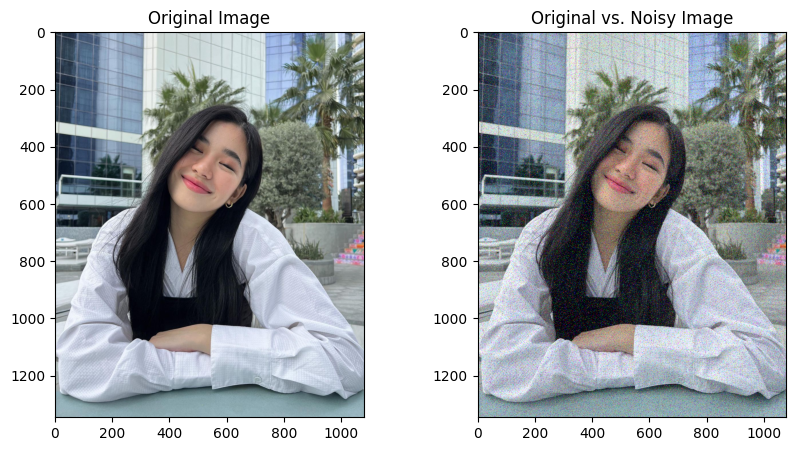

In [53]:

# Adding Noise to an Image

import matplotlib.pyplot as plt
from skimage.util import random_noise

aiah = plt.imread('images/aiah.jpg')

# Add noise to the image
aiah_noisy = random_noise(aiah, mode='s&p', amount=0.10)

# Function to plot the original and noisy images
def plot_comparison(original, filtered, title):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
    ax1.imshow(original)
    ax1.set_title('Original Image')
    ax2.imshow(filtered)
    ax2.set_title(title)
    plt.show()

# Show the original and the noisy image
plot_comparison(aiah, aiah_noisy, 'Original vs. Noisy Image')

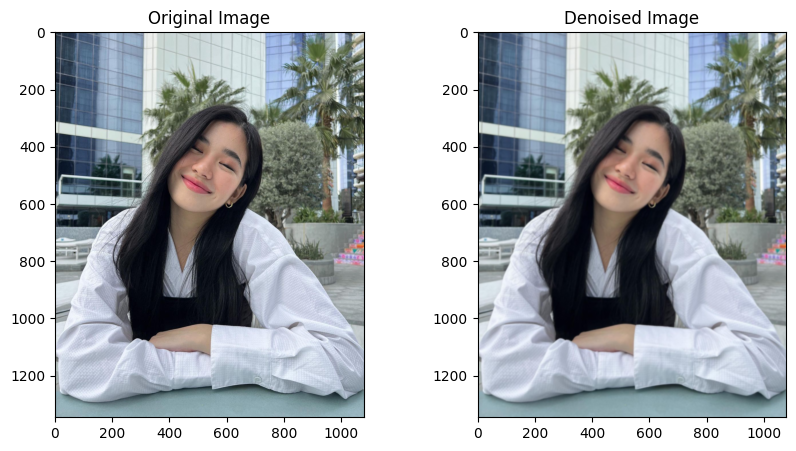

In [54]:
# Reducing Noise
from skimage.restoration import denoise_tv_chambolle

# Apply total variation filter 
denoised_tv_chambolle_aiah = denoise_tv_chambolle(aiah, weight=1.0, eps=0.02, channel_axis=-1) 

# Show the noisy and the denoised image
plot_comparison(aiah, denoised_tv_chambolle_aiah, 'Denoised Image')

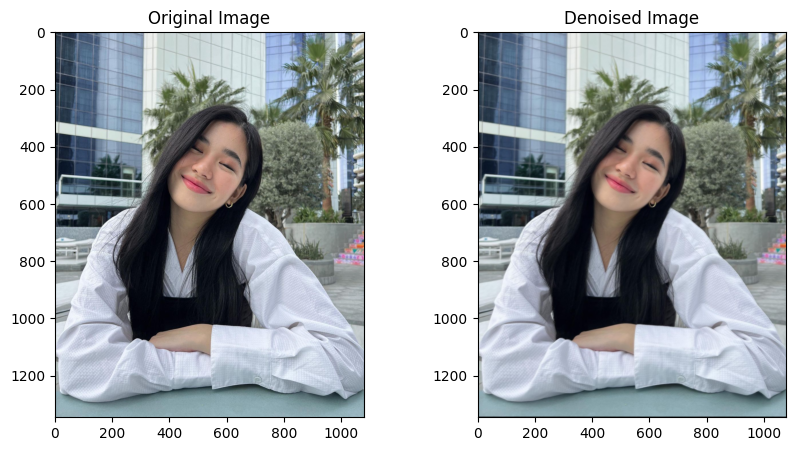

In [55]:
# Reducing Noise while Preserving Edges
from skimage.restoration import denoise_bilateral

# Apply bilateral filter
denoised_bilateral_aiah = denoise_bilateral(aiah, channel_axis=-1)

# Show the noisy and the denoised image
plot_comparison(aiah, denoised_bilateral_aiah, 'Denoised Image')

In [56]:
import cv2 
import numpy as numpy

# Load the image
image = cv2.imread('images/aiah.jpg')

# Apply Gaussian blur
denoised_img = cv2.GaussianBlur(image, (5, 5), 0)

# Save the result 
cv2.imwrite('output/aiah_denoised.jpg', denoised_img)

True

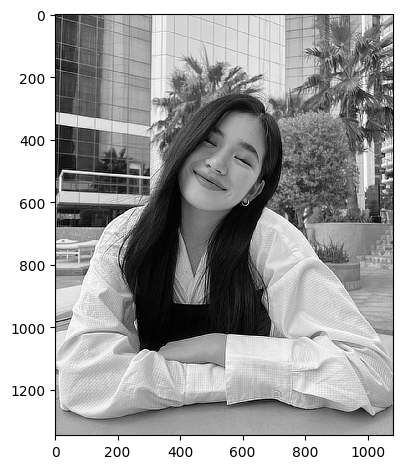

In [57]:
# Debluring Weiner Filter using scikit-image
from skimage import restoration, io, img_as_ubyte, img_as_uint
import pyspark.sql.functions as psf
import numpy as np

# Load the image
img = io.imread('images/aiah.jpg', as_gray=True)

# Apply Weiner filter
deblurred_img = restoration.wiener(img, psf=np.ones((5, 5)) / 25, balance=0.1)

deblurred_img_8bit = img_as_ubyte(deblurred_img)

# Save the result
io.imsave('output/deblurred_weiner_aiah.jpg', deblurred_img_8bit)

# Show the result
io.imshow(deblurred_img_8bit)


# Impainting

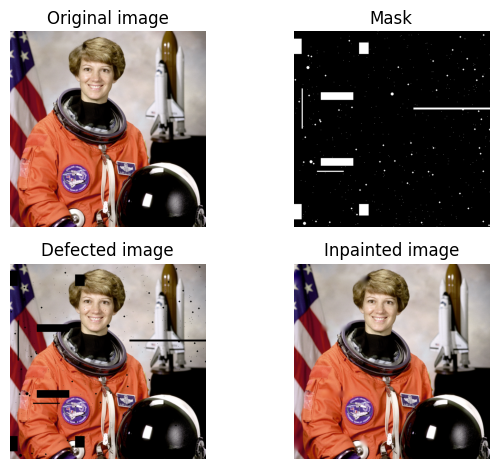

In [58]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import data
from skimage.morphology import disk, binary_dilation
from skimage.restoration import inpaint

image_orig = data.astronaut()

# Create mask with six block defect regions
mask = np.zeros(image_orig.shape[:-1], dtype=bool)
mask[20:60, 0:20] = 1
mask[160:180, 70:155] = 1
mask[30:60, 170:195] = 1
mask[-60:-30, 170:195] = 1
mask[-180:-160, 70:155] = 1
mask[-60:-20, 0:20] = 1

# Add a few long, narrow defects
mask[200:205, -200:] = 1
mask[150:255, 20:23] = 1
mask[365:368, 60:130] = 1

# Add randomly positioned small point-like defects
rstate = np.random.default_rng(0)
for radius in [0, 2, 4]:
    # larger defects are less common
    thresh = 3 + 0.25 * radius  # make larger defects less common
    tmp_mask = rstate.standard_normal(image_orig.shape[:-1]) > thresh
    if radius > 0:
        tmp_mask = binary_dilation(tmp_mask, disk(radius, dtype=bool))
    mask[tmp_mask] = 1

# Apply defect mask to the image over the same region in each color channel
image_defect = image_orig * ~mask[..., np.newaxis]

image_result = inpaint.inpaint_biharmonic(image_defect, mask, channel_axis=-1)

fig, axes = plt.subplots(ncols=2, nrows=2)
ax = axes.ravel()

ax[0].set_title('Original image')
ax[0].imshow(image_orig)

ax[1].set_title('Mask')
ax[1].imshow(mask, cmap=plt.cm.gray)

ax[2].set_title('Defected image')
ax[2].imshow(image_defect)

ax[3].set_title('Inpainted image')
ax[3].imshow(image_result)

for a in ax:
    a.axis('off')

fig.tight_layout()
plt.show()

# Removing Logos


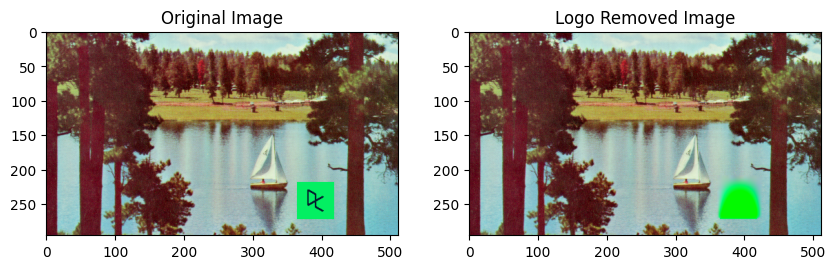

In [59]:
image_with_logo = plt.imread('images/image_with_logo.png')

# Initialize the mask
mask = np.zeros(image_with_logo.shape[:-1])

# Set the pixels where the logo is to 1
mask[210:272, 360:425] = 1

# Apply inpainting to remove the logo
image_logo_removed = inpaint.inpaint_biharmonic(image_with_logo, mask, channel_axis=-1)

# Show the original and logo removed image
plot_comparison(image_with_logo, image_logo_removed, 'Logo Removed Image')

# Image Compression

### Using Pillow

In [60]:
# Using Pillow
from PIL import Image

# Open an image
with Image.open('images/mikha.jpg') as img:
    #Compress the image
    img.save('output/compressed_image_pillow.jpg', quality=80, optimize=True)


### Using OpenCV

In [61]:
# Using OpenCV
import cv2

# Load the image
img = cv2.imread('images/mikha.jpg')

# Compress the image
cv2.imwrite('output/compressed_image_opencv.jpg', img, [int(cv2.IMWRITE_JPEG_QUALITY), 5])

True

### Using Numpy and Singular Value Decomposition (SVD)

In [62]:
import numpy as np
from PIL import Image

def compress_image(image_path, k):
    image = Image.open(image_path)
    image_array = np.array(image) / 255.0  # Normalize the image

    # Initialize a new array to hold the compressed image
    compressed_image = np.zeros_like(image_array)

    # Apply SVD to each channel separately
    for i in range(3):  # For each color channel (R, G, B)
        u, s, v = np.linalg.svd(image_array[:, :, i], full_matrices=False)
        s = np.diag(s[:k])
        compressed_channel = np.dot(u[:, :k], np.dot(s, v[:k, :]))
        compressed_image[:, :, i] = compressed_channel

    return Image.fromarray((compressed_image * 255).astype(np.uint8))

compressed_image = compress_image('images/mikha.jpg', 50)
compressed_image.save('images/compressed_mikha_svd.jpg')



### Fourier Transform for Image Compression

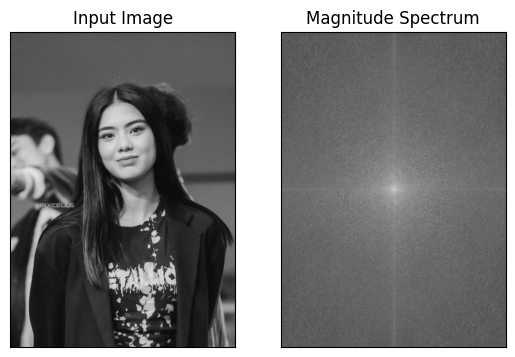

In [63]:
#import libraries
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Read the image
image = cv2.imread('images/mikha.jpg', 0)

# Apply the Fourier transform
f_transform = np.fft.fft2(image)
f_transform_shifted = np.fft.fftshift(f_transform)
magnitude_spectrum = np.log(np.abs(f_transform_shifted) + 1)

# Plot the images for comparison
plt.subplot(121), plt.imshow(image, cmap='gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()

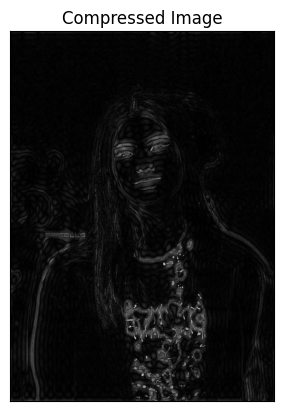

In [64]:
# Compression by removing low frequencies
rows, cols = image.shape
crow, ccol = rows // 2, cols // 2
f_transform_shifted[crow-30:crow+30, ccol-30:ccol+30] = 0  # Removing the center (low frequency) part
f_transform_inverse = np.fft.ifftshift(f_transform_shifted)

# Apply inverse Fourier transform
img_back = np.fft.ifft2(f_transform_inverse)
img_back = np.abs(img_back)

# Normalize the image to the range 0-255
img_back_normalized = cv2.normalize(img_back, None, 0, 255, cv2.NORM_MINMAX)

# Convert to unsigned 8-bit integer type
img_back_normalized = np.uint8(img_back_normalized)

plt.imshow(img_back_normalized, cmap='gray')
plt.title('Compressed Image'), plt.xticks([]), plt.yticks([])
plt.show()

### Wavelet Transform for Image Compression

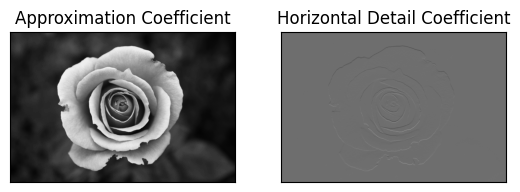

In [65]:
import pywt
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Read the image
image = cv2.imread('images/flower.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale for 2D DWT

# Find the coefficients
coeffs = pywt.dwt2(image, 'bior1.3')
cA, (cH, cV, cD) = coeffs

# Plot the images
plt.subplot(121)
plt.imshow(cA, cmap='gray')
plt.title('Approximation Coefficient')
plt.xticks([]), plt.yticks([])

plt.subplot(122)
plt.imshow(cH, cmap='gray')
plt.title('Horizontal Detail Coefficient')
plt.xticks([]), plt.yticks([])

plt.show()

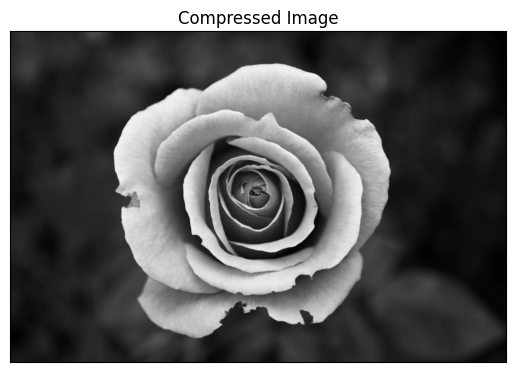

In [66]:
# Apply thresholding
threshold = 10
cA_threshold = pywt.threshold(cA, threshold, mode='soft')
cH_threshold = pywt.threshold(cH, threshold, mode='soft')
cV_threshold = pywt.threshold(cV, threshold, mode='soft')
cD_threshold = pywt.threshold(cD, threshold, mode='soft')

# Compress the Image
coeffs_threshold = (cA_threshold, (cH_threshold, cV_threshold, cD_threshold))
img_compressed = pywt.idwt2(coeffs_threshold, 'bior1.3')

# Show the resulting image after compression
plt.imshow(img_compressed, cmap='gray')
plt.title('Compressed Image')
plt.xticks([]), plt.yticks([])
plt.show()